# Figure 1: 

* A) Mean EKE computed from all-sat over the period 1993-2022.
* B) High EKE regions.

### Import libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as feature
from cartopy.util import add_cyclic_point

### Open masks

In [2]:
masks    = xr.open_dataset('../../results/masks.nc')
ice_mask = masks['no ice'].where(masks['no ice'].notnull(), 1.1)
ice_mask = ice_mask.where(ice_mask != 1, float('nan'))

### Load the mean EKE data (1993-2022) 

In [3]:
# ALL SAT REP
ds_all = xr.open_dataset('../../results/EKE_ALL_SAT/tmean/EKE_ALL_SAT_tmean.nc')
eke_all = (ds_all.EKE) # cm2 s-2
# TWO SAT REP
ds_two = xr.open_dataset('../../results/EKE_TWO_SAT/tmean/EKE_TWO_SAT_tmean.nc')
eke_two = (ds_two.EKE) # cm2 s-2


### In subplot A show also the high EKE regions + tropical band, open data here

In [4]:
# Define tropical region (reindexing to avoid discontinuity at 180° when plotting)
da_trop      = masks['tropical'].where(masks['tropical'].notnull(), 0)
lon          = masks.coords['lon']
lon_idx      = da_trop.dims.index('lon')
wrap_data, wrap_lon = add_cyclic_point(da_trop.values, coord=lon, axis=lon_idx)
tropical     = xr.DataArray(wrap_data, coords = {'lat': masks['lat'], 'lon': wrap_lon})

# Define high EKE region
high_eke     = masks['high eke'].where(masks['high eke'].notnull(), 0)

### Show in subplot B only the high EKE regions 

In [5]:
keys_excluded    = ['no ice', 'high eke', 'tropical', 'remainder']

ds_maskso   = masks.drop_vars(keys_excluded)

# mask is 1 or 0, only keep values = 1, NaN values = 0
ds_masks    = ds_maskso.where(ds_maskso != 0)

## FIGURE 1

### Figure parameters

In [6]:

fig_size   = 20
ratio      = 0.7
text_size  = 0.25 + 0.1
dpi        = 300
extension  = 'png'


# Parameter for mean EKE maps

vmins   = [0]
vmaxs   = [3000]
extends = ['max']
cmaps   = ['plasma']

titles     = [r'$\it{all}$-$\it{sat}$ mean EKE (1993-2022)']
label_unit = "(cm$^2$ s$^{-2}$)"

ccrs_land = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='navajowhite',
                                        linewidth=0.2)
 

### Plot figure

/Users/bbarcelo/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'hatch_linewidth'
  result = super().contourf(*args, **kwargs)
/Users/bbarcelo/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


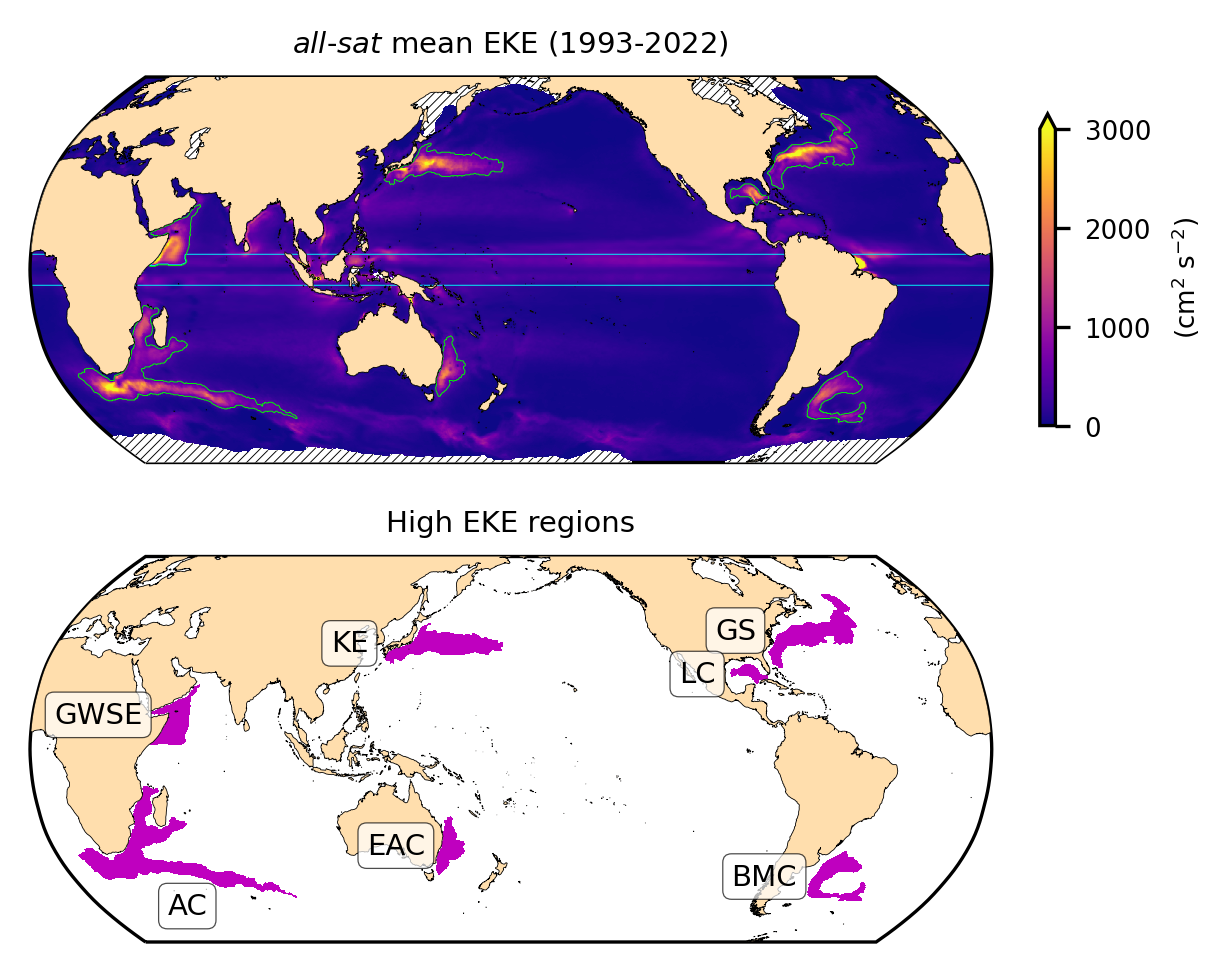

In [7]:
fs = 7

fig = plt.figure(figsize=(4,3.2), dpi=300,
                     layout='constrained')

gs = mpl.gridspec.GridSpec(2, 1, height_ratios = [1,1], figure=fig)


''' Mean EKE '''

mpl.rcParams['hatch.linewidth'] = 0.05*np.sqrt(fig_size)
    
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.Robinson(central_longitude=180))
ax1.add_feature(ccrs_land, zorder=5)
        
# Show ice mask
xr.plot.contourf(ice_mask, transform=ccrs.PlateCarree(),
                             hatches=['///////////'],
                             hatch_linewidth=0.01*np.sqrt(fig_size),
                             alpha=1,
                             cmap='w',
                             add_colorbar=False,
                             zorder=4,
                             ax=ax1)
        
# Show in the first subplot the high EKE regions and the tropical band  
 
tropical.plot.contour(transform=ccrs.PlateCarree(),
                       levels=[0, 1],
                       colors='cyan', #'b',#'darkblue',
                       linewidths=0.05*np.sqrt(fig_size),
                       #linestyles='dotted',
                       zorder=2,
                       ax = ax1)

high_eke.plot.contour(transform=ccrs.PlateCarree(),
                           levels=[0, 1],
                           colors='lime', #'red',#'darkred',
                           linewidths=0.05*np.sqrt(fig_size),
                           zorder=2,
                           ax = ax1)

# Map mean EKE
im = eke_all.plot(transform=ccrs.PlateCarree(),
                 cmap=cmaps[0],
                 vmin=vmins[0], vmax=vmaxs[0],
                 add_colorbar=False,
                 ax=ax1)

ax1.set_title(titles[0], fontsize=fs)

cbar = fig.colorbar(im, orientation='vertical',
                            extend=extends[0],
                            shrink=0.75,
                            pad=0.05,
                            ax=ax1,
                            location='right')

cbar.ax.tick_params(labelsize=4*text_size*np.sqrt(fig_size))


cbar.set_label(label_unit,
                       fontsize=4*text_size*np.sqrt(fig_size),
                       labelpad=np.sqrt(fig_size))        
        


''' High EKE regions '''

ax2 = fig.add_subplot(gs[1, 0],projection=ccrs.Robinson(central_longitude=180))
ax2.add_feature(ccrs_land, zorder=5)


for region in ds_masks.keys():
    
    ds_masks[region].plot.pcolormesh(transform=ccrs.PlateCarree(),
                                     add_colorbar=False, # Set cbar_kwargs to None
                                     levels=2,
                                     colors='m')  

    # Add text labels near each region
    
    # An array with values only where mask=1 (the others are removed)
    masked_data  = ds_masks[region].where(ds_masks[region] == 1, drop=True)   
    centroid_lon = masked_data.lon.min().values
    centroid_lat = masked_data.lat.mean().values
    
    if region == 'AC':
        
        text = ax2.text(masked_data.lon.mean().values-10, 
                             masked_data.lat.min().values-3, 
                             region, 
                  transform=ccrs.PlateCarree(), color='black', 
                  fontsize=fs, ha='center', va='center', 
                  bbox=dict(boxstyle="round",
                   ec='k',
                   fc='w',
                   linewidth=0.3,
                   alpha=0.7),
                   zorder=100)
        
    elif np.logical_or(region == 'GWSE',  region =='BMC'):
        
        text = ax2.text(centroid_lon-20, centroid_lat, region, 
                  transform=ccrs.PlateCarree(), color='black', 
                  fontsize=fs, ha='center', va='center', 
                  bbox=dict(boxstyle="round",
                   ec='k',
                   fc='w',
                   linewidth=0.3,
                   alpha=0.7),
                   zorder=100)  

    elif region == 'GS':   
        text = ax2.text(centroid_lon-10, centroid_lat, region, 
                  transform=ccrs.PlateCarree(), color='black', 
                  fontsize=fs, ha='center', va='center', 
                  bbox=dict(boxstyle="round",
                   ec='k',
                   fc='w',
                   linewidth=0.3,
                   alpha=0.7),
                   zorder=100)           
    elif np.logical_or(region == 'KE',  region =='EAC'):
        
        text = ax2.text(centroid_lon-15, centroid_lat, region, 
                  transform=ccrs.PlateCarree(), color='black', 
                  fontsize=fs, ha='center', va='center', 
                  bbox=dict(boxstyle="round",
                   ec='k',
                   fc='w',
                   linewidth=0.3,
                   alpha=0.7),
                   zorder=100)    
        
    else:    
        text = ax2.text(centroid_lon-13, centroid_lat, region, 
                  transform=ccrs.PlateCarree(), color='black', 
                  fontsize=fs, ha='center', va='center', 
                  bbox=dict(boxstyle="round",
                   ec='k',
                   fc='w',
                   linewidth=0.3,
                   alpha=0.7),
                   zorder=100)   
    

ax2.set_title('High EKE regions', fontsize=fs)


''' Save figure '''

savepath = f'../../figures/Fig_1.{extension}'
dir_path = os.path.dirname(os.path.realpath(savepath))+'/'
if not os.path.exists(dir_path):
        os.makedirs(dir_path)
plt.savefig(savepath, dpi=500, bbox_inches='tight')